# Deep Learning with RatInABox [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RatInABox-Lab/RatInABox/blob/main/demos/deep_learning_example.ipynb)

In this tutorial we will show how `NeuralNetworkNeurons` can be used as general function approximators to make RatInABox `Neurons` classes which can be "trained" to represent any function. 

Inside each `NeuralNetworkNeurons` class is a user-defined `pytorch` neural network. We'll show how to set this us with whatever architecture you want and then how to train it.

Here's the jist of what we'll do:

<img src="../.images/demos/dnn.png" width="400" align="center">


In [1]:
!pip install ratinabox
!pip install torch torchsummary

In [2]:
import ratinabox 
from ratinabox.Environment import Environment 
from ratinabox.Agent import Agent
from ratinabox.Neurons import Neurons, PlaceCells, RandomSpatialNeurons, GridCells
from ratinabox.contribs.NeuralNetworkNeurons import NeuralNetworkNeurons
ratinabox.autosave_plots = True; ratinabox.figure_directory = "../figures/"; ratinabox.stylize_plots()

import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [5]:
#Globals 
N_FEATURES = 200 # number of input features
HIDDEN_LAYER_SIZES = [100,100,100] # number of neurons in each hidden layer
LR = 2*1e-3 # learning rate
L2 = 1e-5 # L2 regularization
TAU_E = 10 # eligibilty trace timescale for SGD smoothing

Before we start we'll make the standard square Environment and put an Agent inside it. The agents motion inside this environment will gernerate the data which will train the neural network.

In [6]:
Env = Environment() # 1mm for high resolution plotting 
Ag = Agent(Env,params={'dt':0.1})

## Lets make the target function for our neural network

First we'll load in a `.png` image which will act as the target function for the neural network. We'll load it into a `numpy` array using `PIL` then interpolated it so we can smoothly evalate the target at any location in the `Environment`.

**Note: You don't have to make a `Neurons` class to represent your target function.** You can calculate the target however you like. We're only doing this because it's convenient later. 


In [7]:
from PIL import Image
import scipy 

class ImageNeurons(Neurons):
    """Recieves any .png image, normalises it, and scales it to fill the environment. The firing rate of the neuron is then the value of the image at the Agents current position."""
    default_params = {"image_path":None}
    def __init__(self,Ag,params={}):
        params['n']=1
        super().__init__(Ag,params)
        self.image = np.array(Image.open(self.image_path))[:,:,0]/255  # load image and normalise
        extent = self.Agent.Environment.extent
        self.X = np.linspace(extent[0],extent[1],self.image.shape[1])
        self.Y = np.linspace(extent[2],extent[3],self.image.shape[0])[::-1]
        self.image_interpolated = scipy.interpolate.RegularGridInterpolator(points=(self.Y,self.X),values=self.image) # create interpolator
    def get_state(self,evaluate_at="agent"):
        if evaluate_at == "agent":
            pos = self.Agent.pos
        elif evaluate_at == "all":
            pos = self.Agent.Environment.flattened_discrete_coords
        else:
            pos = kwargs["pos"]
        pos = np.array(pos).reshape(-1, pos.shape[-1])
        firingrate = self.image_interpolated((pos[:,1],pos[:,0])).reshape(self.n,-1) # evaluate image at position (or array of positions)
        return firingrate
    

Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/23_10_23/Neurons_ratemaps_1134.png  & .svg


Text(0.5, 0.98, 'The target image')

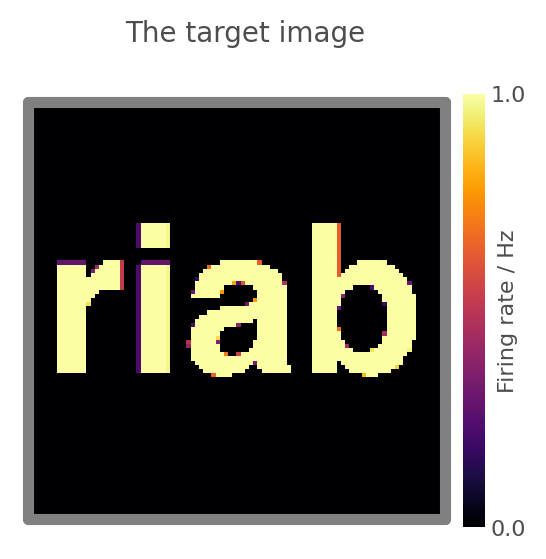

In [8]:
Target = ImageNeurons(Ag,params={"image_path":"../../.images/demos/riab_target.png"})

#Show it and some generated data 
fig, ax = Target.plot_rate_map()
fig.suptitle("The target image")


## `NeuralNetworkNeurons` as general function approximators

`NeuralNetworkNeurons` are a type of RatInABox `Neurons` which take other `Neurons` as inputs and map these through a trainable pytorch neural network to calculate the firingrate. As is typical in deep learning we'll need 

* A pytorch **neural network module**  to approximate the function: `neural_network_module`
* A **loss function** to compare the output of the network to the target function: `loss_function()`
* An **optimiser** to train the network: `optimiser`


### The neural network module
`NeuralNetworkNeurons` are initialised with an attribute called `self.NeuralNetworkModule` which is _any_ `pytorch.nn.Module` class. (Note: if you don't supply one  RatInABox will initialse a default one for you). This network must accept the same number of inputs as the `NeuralNetworkNeurons` recieve and output as many values as there are neurons in this layer (in this case, just a single value)

In [9]:
import torch 
import torch.nn as nn
import torchsummary 

#Generic neural network class
class MultiLayerPerceptron(nn.Module):
    def __init__(self, n_in=100, n_out=1, n_hidden=[100,100]):
        nn.Module.__init__(self)
        n = [n_in] + n_hidden + [n_out]
        layers = nn.ModuleList()
        for i in range(len(n)-1):
            layers.append(nn.Linear(n[i],n[i+1]))
            if i < len(n)-2: layers.append(nn.ReLU()) #add a ReLU after each hidden layer (but not the last)
        self.net = nn.Sequential(*layers)
    def forward(self, X):
        return self.net(X)

In [10]:
neural_network_module = MultiLayerPerceptron(n_in=N_FEATURES, n_hidden = HIDDEN_LAYER_SIZES, n_out=1)

#and print details (optional)
print("This is the neural network which will sit inside the neuron class:")
torchsummary.summary(neural_network_module, input_size=(N_FEATURES,))

This is the neural network which will sit inside the neuron class:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          20,100
              ReLU-2                  [-1, 100]               0
            Linear-3                  [-1, 100]          10,100
              ReLU-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,100
              ReLU-6                  [-1, 100]               0
            Linear-7                    [-1, 1]             101
Total params: 40,401
Trainable params: 40,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


### Loss function 
Neural networks typically need a loss function. We'll use the mean squared error between the output of the network and the target function.

In [11]:
def loss_function(output, target):
    """Takes the output and input and returns the loss. This function will work whether you pass these in as numpy or torch arrays but, of course, loss will only be backpropagatable if the output is a torch tensor attached to the computational graph."""
    #Make sure they're both torch tensors 
    if isinstance(output, np.ndarray): output = torch.from_numpy(output)
    if isinstance(target, np.ndarray): target = torch.from_numpy(target)
    #Calculate the mean squared error 
    loss = torch.mean((output - target)**2)
    return loss


# Lists to save loss into and a function to plot it
Ag.history['loss'] = [] #<-- we'll store loss data over training here
def plot_loss_history(losses):
    """Plots the loss history. Losses is a list of [[time,loss],...]"""
    losses = np.array(losses)
    fig, ax = plt.subplots(figsize=(4,2))
    ax.plot(losses[:,0]/60,losses[:,1],alpha=1,c='C2')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Loss")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,max(losses[:,1])+0.01)
    return fig, ax

### Optimiser 
We'll also make an optimiser to train the neural network. Here's we'll use standard stochastic gradient descent with momentum SGD with momentum $\mu = (1 - \frac{dt}{\tau_e})$ is equivalent to SGD with decaying eligibilty trace of timescale $\tau_e$.  

In [12]:
optimiser = torch.optim.SGD(neural_network_module.parameters(), lr=LR*Ag.dt**2, momentum=(1-(Ag.dt/TAU_E)), weight_decay=L2,nesterov=True)

### Making the `NeuralNetworkNeurons`

Now let's make the `NeuralNetworkneurons`. We'll have them recieve as input 200 RatInABox `GridCells`


The elegance is that since this neurla network is embedded in a RatInABox `Neurons` class, it follows the RatInABox API. So we can query the firing rate at any position in the environment, or plot its rate map across the environment.

Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/23_10_23/GridCells_ratemaps_1134.png  & .svg
Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/23_10_23/NeuralNetworkNeurons_ratemaps_1134.png  & .svg


Text(0.5, 0.98, 'Neural network before training')

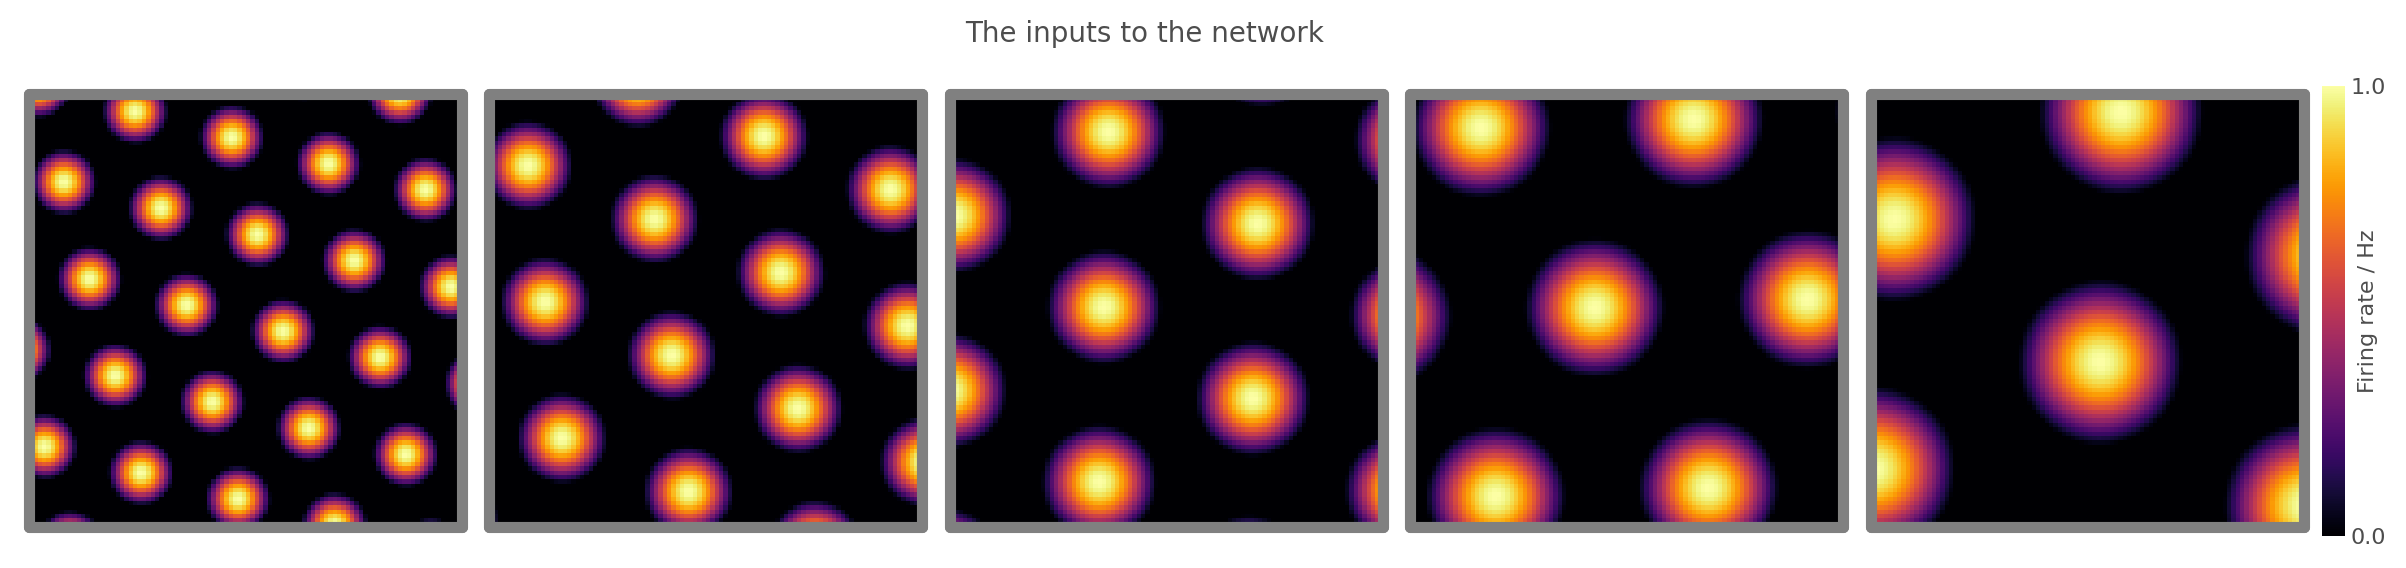

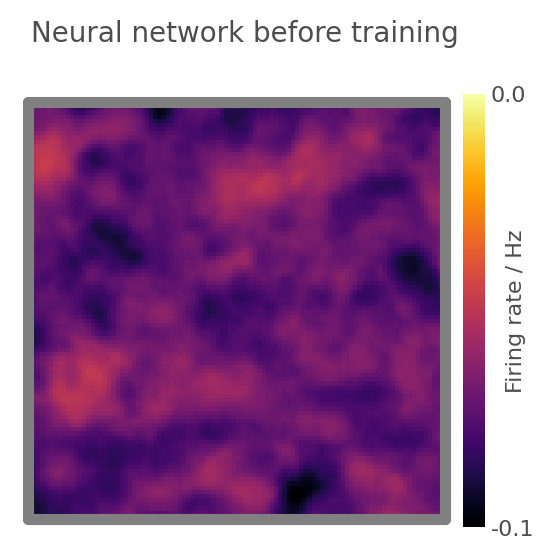

In [13]:
Inputs = GridCells(Ag,params={
                            'n':N_FEATURES,
                            'gridscale':np.linspace(0.2,0.5,N_FEATURES)})

NNN = NeuralNetworkNeurons(Ag, params={'input_layers':[Inputs], #<-- the inputs to the network 
                                       'NeuralNetworkModule':neural_network_module, #<-- the neural network which maps these inputs to outputs 
                                       })

# Visualise 
fig, ax = Inputs.plot_rate_map(chosen_neurons='5')
fig.suptitle("The inputs to the network")
fig, ax = NNN.plot_rate_map()
fig.suptitle("Neural network before training")

## Training loop

Time (min): 300, Loss: 0.0168: 100%|██████████| 180000/180000 [07:08<00:00, 420.47it/s]


Figure saved to /Users/tomgeorge/Documents/RatInABox/figures/23_10_23/DNN_training_samples_1141.png  & .svg


'../../figures/23_10_23/DNN_training_samples_1141'

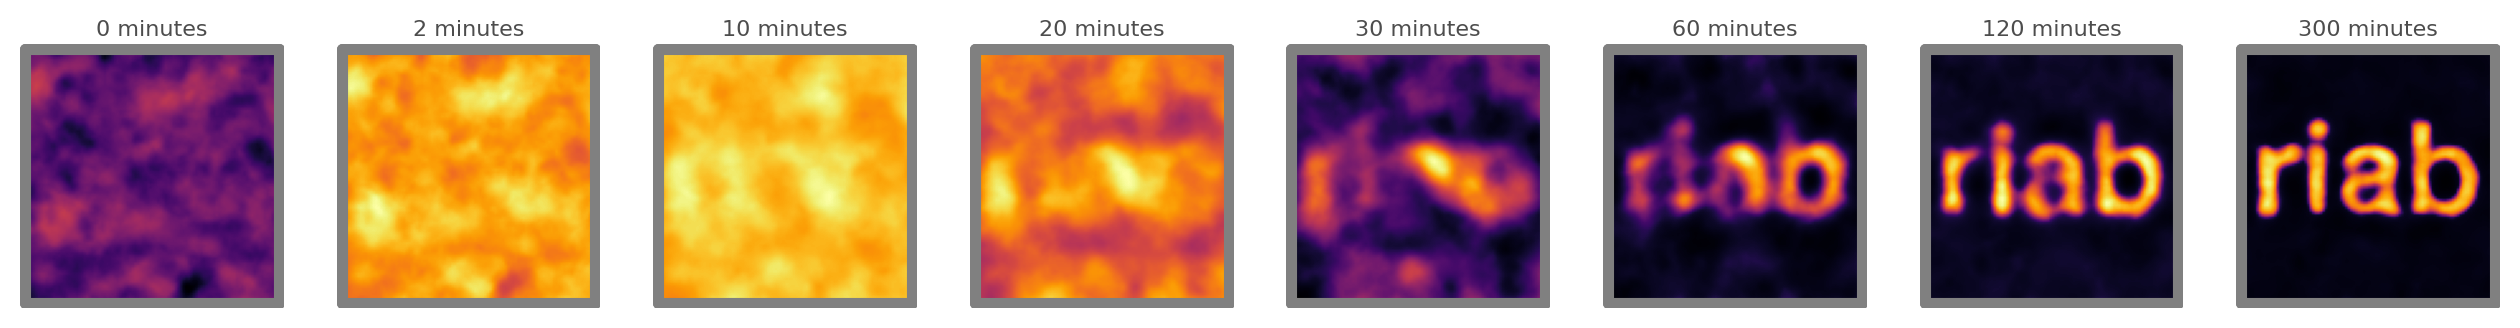

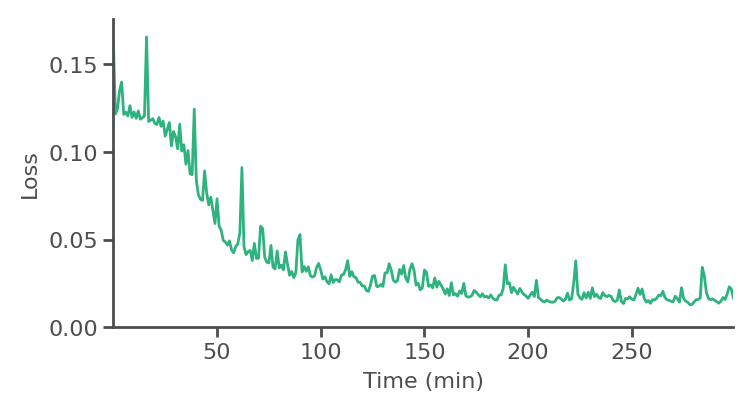

In [14]:
TRAIN_MINS = 300
VISUALISE_MINS = [0, 2, 10, 20, 30, 60, 120, 300]; j = 0
fig, ax = plt.subplots(1,len(VISUALISE_MINS),figsize=(len(VISUALISE_MINS)*2,2))
try: 
    for i in (pbar := tqdm(range(int((TRAIN_MINS*60)/Ag.dt)))):
        #update neurons
        Ag.update()
        Inputs.update()
        NNN.update()
        Target.update()

        #zero gradients
        NNN.NeuralNetworkModule.zero_grad()

        #backpropagate
        loss = loss_function(output=NNN.firingrate_torch,
                             target=Target.firingrate)
        loss.backward()
        optimiser.step()
        
        #Every minute esitmate loss over entire environment
        if i % int(60/Ag.dt) == 0:
            full_loss = loss_function(output = NNN.get_state(evaluate_at='all'),
                                  target = Target.get_state(evaluate_at='all'))
            Ag.history['loss'].append([Ag.t,full_loss.item()])

        #Visualise if time cross one in visualise_mins
        if int(Ag.t/60) in VISUALISE_MINS:
            NNN.plot_rate_map(fig=fig, ax=ax[j], autosave=False, colorbar=False)
            ax[j].set_title(f"{int(Ag.t/60)} minutes")
            VISUALISE_MINS.pop(0); j += 1 

        pbar.set_description(f"Time (min): {int(Ag.t/60)}, Loss: {full_loss:.4f}")
except KeyboardInterrupt: #allow user to interupt the simulation
    pass


plot_loss_history(Ag.history['loss'])
ratinabox.utils.save_figure(fig, "DNN_training_samples")